In [1]:
!pip install timm
!pip install torchcontrib

     |████████████████████████████████| 346 kB 1.1 MB/s 
  Created wheel for torchcontrib: filename=torchcontrib-0.0.2-py3-none-any.whl size=7533 sha256=32c5b56298f5b75e63daefc74f8512dc52939a6bb8b8e1d4fb0fecc09e9bd272
  Stored in directory: /root/.cache/pip/wheels/91/58/d0/f03811c3e34e1f14031294b5f30d8693689972af874d1225b8
Successfully built torchcontrib


In [2]:
import os
import numpy as np
import pytorch_lightning as pl
import torch
import pandas as pd
import timm
import torch.nn as nn

from PIL import Image
from sklearn.model_selection import KFold
from torchvision import transforms as tsfm
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.metrics import Metric
from torchcontrib.optim import SWA


### How to change the backbone CNN of the model?
The backbone of the model are CNN from the [timm](https://rwightman.github.io/pytorch-image-models/models/), which is a CNN library of pytorch.

If you want to change to different CNN model, modify: CFG.model_name. e.g. model_name = "vit_base_patch16_224" then you will change the backbone into "Vision Transformer"



In [3]:
class CFG:
    # data path
    train_csv_path = '../input/plant-pathology-2021-fgvc8/train.csv'
    train_imgs_dir = '../input/pp2021-train-images-resized/224_square_not_crop'
    # label info
    label_num2str = {0: 'powdery_mildew',
                     1: 'scab',
                     2: 'complex',
                     3: 'frog_eye_leaf_spot',
                     4: 'rust'}
    
    label_str2num = {'powdery_mildew': 0,
                     'scab': 1,
                     'complex': 2,
                     'frog_eye_leaf_spot': 3,
                     'rust': 4}
    # model info
    model_name = 'vit_base_patch16_224'
    # training hyper-parameters
    fl_alpha = 1.0  # alpha of focal_loss
    fl_gamma = 2.0  # gamma of focal_loss
    cls_weight = [3.6480, 1.0001, 2.1840, 1.5001, 2.2901] # class weights for we calculating loss
    use_swa = True
    seed = 77
    num_classes = 5
    num_epochs = 17
    batch_size = 64
    t_max = 18
    lr = 1e-3
    min_lr = 1e-6
    n_fold = 6
    num_workers = 8
    accum_grad_batch = 1
    early_stop_delta = 1e-7
    # if you have multi-GPU on your machine, set gpu_list to [0, 1, ...]
    gpu_idx = 0
    device = torch.device(f'cuda:{gpu_idx}' if torch.cuda.is_available() else 'cpu')
    gpu_list = [gpu_idx]


In [4]:
seed_everything(CFG.seed)

77

In [5]:
"""
Add numerical labels for dataframe
"""
TRAIN_DF = pd.read_csv(CFG.train_csv_path)

all_numeric_labels = []
for row_idx, row in TRAIN_DF.iterrows():
    labels_list = row['labels'].split(" ")
    numeric_label_list = [CFG.label_str2num[each] for each in labels_list if each != 'healthy']
    all_numeric_labels.append(numeric_label_list)
TRAIN_DF['numerical labels'] = all_numeric_labels
TRAIN_DF

image                           labels numerical labels
0      800113bb65efe69e.jpg                          healthy               []
1      8002cb321f8bfcdf.jpg  scab frog_eye_leaf_spot complex        [1, 3, 2]
2      80070f7fb5e2ccaa.jpg                             scab              [1]
3      80077517781fb94f.jpg                             scab              [1]
4      800cbf0ff87721f8.jpg                          complex              [2]
...                     ...                              ...              ...
18627  fffb900a92289a33.jpg                          healthy               []
18628  fffc488fa4c0e80c.jpg                             scab              [1]
18629  fffc94e092a59086.jpg                             rust              [4]
18630  fffe105cf6808292.jpg          scab frog_eye_leaf_spot           [1, 3]
18631  fffe472a0001bd25.jpg                          healthy               []

[18632 rows x 3 columns]

In [6]:
"""
Define train & valid image transformation
"""
DATASET_IMAGE_MEAN = (0.485, 0.456, 0.406)
DATASET_IMAGE_STD = (0.229, 0.224, 0.225)

train_transform = tsfm.Compose([tsfm.RandomApply([tsfm.ColorJitter(0.2, 0.2, 0.2),tsfm.RandomPerspective(distortion_scale=0.2),], p=0.3),
                                tsfm.RandomApply([tsfm.ColorJitter(0.2, 0.2, 0.2),tsfm.RandomAffine(degrees=10),], p=0.3),
                                tsfm.RandomVerticalFlip(p=0.3),
                                tsfm.RandomHorizontalFlip(p=0.3),
                                tsfm.ToTensor(),
                                tsfm.Normalize(DATASET_IMAGE_MEAN, DATASET_IMAGE_STD), ])

valid_transform = tsfm.Compose([tsfm.ToTensor(),
                                tsfm.Normalize(DATASET_IMAGE_MEAN, DATASET_IMAGE_STD), ])

In [7]:
"""
Define dataset class
"""
class PlantDataset(Dataset):
    def __init__(self, cfg, img_names: list, labels: list, transform=None):
        self.img_dir = cfg.train_imgs_dir
        self.img_names = img_names
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        img = Image.open(img_path).convert('RGB')
        img_ts = self.transform(img)
        label_ts = self.labels[idx]
        return img_ts, label_ts

In [8]:
"""
Define Focal-Loss
"""

class FocalLoss(nn.Module):
    """
    The focal loss for fighting against class-imbalance
    """
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = 1e-12  # prevent training from Nan-loss error
        self.cls_weights = torch.tensor([CFG.cls_weight],dtype=torch.float, requires_grad=False, device=CFG.device)

    def forward(self, logits, target):
        """
        logits & target should be tensors with shape [batch_size, num_classes]
        """
        probs = torch.sigmoid(logits)
        one_subtract_probs = 1.0 - probs
        # add epsilon
        probs_new = probs + self.epsilon
        one_subtract_probs_new = one_subtract_probs + self.epsilon
        # calculate focal loss
        log_pt = target * torch.log(probs_new) + (1.0 - target) * torch.log(one_subtract_probs_new)
        pt = torch.exp(log_pt)
        focal_loss = -1.0 * (self.alpha * (1 - pt) ** self.gamma) * log_pt
        focal_loss = focal_loss * self.cls_weights
        return torch.mean(focal_loss)
        

In [9]:
"""
Define F1 score metric
"""
class MyF1Score(Metric):
    def __init__(self, cfg, threshold: float = 0.5, dist_sync_on_step=False):
        super().__init__(dist_sync_on_step=dist_sync_on_step)
        self.cfg = cfg
        self.threshold = threshold
        self.add_state("tp", default=torch.tensor(0), dist_reduce_fx="sum")
        self.add_state("fp", default=torch.tensor(0), dist_reduce_fx="sum")
        self.add_state("fn", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        assert preds.shape == target.shape
        preds_str_batch = self.num_to_str(torch.sigmoid(preds))
        target_str_batch = self.num_to_str(target)
        tp, fp, fn = 0, 0, 0
        for pred_str_list, target_str_list in zip(preds_str_batch, target_str_batch):
            for pred_str in pred_str_list:
                if pred_str in target_str_list:
                    tp += 1
                if pred_str not in target_str_list:
                    fp += 1

            for target_str in target_str_list:
                if target_str not in pred_str_list:
                    fn += 1
        self.tp += tp
        self.fp += fp
        self.fn += fn

    def compute(self):
        f1 = 2.0 * self.tp / (2.0 * self.tp + self.fn + self.fp)
        return f1
    
    def num_to_str(self, ts: torch.Tensor) -> list:
        batch_bool_list = (ts > self.threshold).detach().cpu().numpy().tolist()
        batch_str_list = []
        for one_sample_bool in batch_bool_list:
            lb_str_list = [self.cfg.label_num2str[lb_idx] for lb_idx, bool_val in enumerate(one_sample_bool) if bool_val]
            if len(lb_str_list) == 0:
                lb_str_list = ['healthy']
            batch_str_list.append(lb_str_list)
        return batch_str_list

In [10]:
"""
Define neural network model
"""

class MyNetwork(pl.LightningModule):
    def __init__(self, cfg):
        super(MyNetwork, self).__init__()
        self.cfg = cfg
        self.model = timm.create_model(cfg.model_name, pretrained=True, num_classes=cfg.num_classes)
        self.criterion = FocalLoss(cfg.fl_alpha, cfg.fl_gamma)
        self.metric = MyF1Score(cfg)
       
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        if self.cfg.use_swa:
            self.optimizer = SWA(torch.optim.Adam(self.model.parameters(), lr=self.cfg.lr))
        else:
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.cfg.lr)
            
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer,
                                                                    T_max=self.cfg.t_max,
                                                                    eta_min=self.cfg.min_lr,
                                                                    verbose=True)
        return {'optimizer': self.optimizer, 'lr_scheduler': self.scheduler}
    
    def training_step(self, batch, batch_idx):
        img_ts, lb_ts = batch
        pred_ts = self.model(img_ts)
        loss = self.criterion(pred_ts, lb_ts)
        score = self.metric(pred_ts, lb_ts)
        logs = {'train_loss': loss, 'train_f1': score, 'lr': self.optimizer.param_groups[0]['lr']}
        self.log_dict(logs, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        img_ts, lb_ts = batch
        pred_ts = self.model(img_ts)
        loss = self.criterion(pred_ts, lb_ts)
        score = self.metric(pred_ts, lb_ts)
        logs = {'valid_loss': loss, 'valid_f1': score}
        self.log_dict(logs, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

In [11]:
"""
Split train & validation into Cross-Validation Folds
"""

all_img_names: list = TRAIN_DF["image"].values.tolist()
all_img_labels: list = TRAIN_DF["numerical labels"].values.tolist()
print("Befor reomve duplicates:", len(all_img_names), ", ", len(all_img_labels))
    
"""
Remove duplicated samples from the training image
"""
dplct_csv_path = "../input/duplicate-images-csv/duplicates.csv"
dplct_pd = pd.read_csv(dplct_csv_path)
dplct_img_names = dplct_pd.iloc[:, 0].values.tolist() + dplct_pd.iloc[:, 1].values.tolist()
dplct_img_names = list(set(dplct_img_names))
print("Num of duplicated samples: ", len(dplct_img_names))

img_names_no_dplct = []
img_labels_no_dplct = []
for img_name, img_label in zip(all_img_names, all_img_labels):
    if img_name not in dplct_img_names:
        img_names_no_dplct.append(img_name)
        img_labels_no_dplct.append(img_label)
        
all_img_names = img_names_no_dplct
all_img_labels = img_labels_no_dplct
print("After reomve duplicates:", len(all_img_names), ", ", len(all_img_labels))
    
all_img_labels_ts = []
for tmp_lb in all_img_labels:
    tmp_label = torch.zeros([CFG.num_classes], dtype=torch.float)
    for idx in tmp_lb:
        tmp_label[idx] = 1.0
    all_img_labels_ts.append(tmp_label)
    
k_fold = KFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)

Befor reomve duplicates: 18632 ,  18632
Num of duplicated samples:  98
After reomve duplicates: 18534 ,  18534


In [12]:
"""
Training
"""

for fold_idx, (train_indices, valid_indices) in enumerate(k_fold.split(all_img_names)):
    """
    Init trainer
    """
    logger = CSVLogger(save_dir=f'fold{fold_idx}_logs/', name=CFG.model_name)
    logger.log_hyperparams(CFG.__dict__)
    checkpoint_callback = ModelCheckpoint(monitor='valid_f1',
                                          save_top_k=1,
                                          save_last=True,
                                          save_weights_only=True,
                                          filename='best_perform',
                                          verbose=False,
                                          mode='max')
    early_stop_callback = EarlyStopping(monitor='valid_loss', min_delta=CFG.early_stop_delta, patience=3, mode='min')

    trainer = Trainer(max_epochs=CFG.num_epochs,
                      gpus=1,
                      accumulate_grad_batches=CFG.accum_grad_batch,
                      # callbacks=[early_stop_callback],
                      checkpoint_callback=checkpoint_callback,
                      logger=logger,
                      weights_summary='top',)
    """
    Init dataset & dataloader
    """
    # get image names and labels
    fold_train_img_names = [all_img_names[idx] for idx in train_indices]
    fold_valid_img_names = [all_img_names[idx] for idx in valid_indices]
    fold_train_img_labels = [all_img_labels_ts[idx] for idx in train_indices]
    fold_valid_img_labels = [all_img_labels_ts[idx] for idx in valid_indices]
    # dataset
    train_dataset = PlantDataset(CFG, fold_train_img_names, fold_train_img_labels, train_transform)
    valid_dataset = PlantDataset(CFG, fold_valid_img_names, fold_valid_img_labels, valid_transform)
    # dataloader
    train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers)
    
    
    """
    Init model
    """
    model = MyNetwork(CFG)
    
    """
    Fit(train) the model
    """
    trainer.fit(model, train_dataloader=train_loader, val_dataloaders=valid_loader)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth" to /root/.cache/torch/hub/checkpoints/jx_vit_base_p16_224-80ecf9dd.pth


Adjusting learning rate of group 0 to 1.0000e-03.


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/core/saving.py:402: UserWarning: Skipping '__dict__' parameter because it is not possible to safely dump to YAML.
  warn(f"Skipping '{k}' parameter because it is not possible to safely dump to YAML.")
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/core/saving.py:402: UserWarning: Skipping '__weakref__' parameter because it is not possible to safely dump to YAML.
  warn(f"Skipping '{k}' parameter because it is not possible to safely dump to YAML.")


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.9241e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.6988e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.3308e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 8.8314e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 8.2157e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 7.5025e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.7134e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 5.8724e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 5.0050e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 4.1376e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.2966e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.5075e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.7943e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.1786e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.7920e-05.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.1124e-05.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 8.5885e-06.
Adjusting learning rate of group 0 to 1.0000e-03.


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.9241e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.6988e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.3308e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 8.8314e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 8.2157e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 7.5025e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.7134e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 5.8724e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 5.0050e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 4.1376e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.2966e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.5075e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.7943e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.1786e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.7920e-05.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.1124e-05.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 8.5885e-06.
Adjusting learning rate of group 0 to 1.0000e-03.


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.9241e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.6988e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.3308e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 8.8314e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 8.2157e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 7.5025e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.7134e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 5.8724e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 5.0050e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 4.1376e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.2966e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.5075e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.7943e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.1786e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.7920e-05.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.1124e-05.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 8.5885e-06.
Adjusting learning rate of group 0 to 1.0000e-03.


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.9241e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.6988e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.3308e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 8.8314e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 8.2157e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 7.5025e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.7134e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 5.8724e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 5.0050e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 4.1376e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.2966e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.5075e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.7943e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.1786e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.7920e-05.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.1124e-05.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 8.5885e-06.
Adjusting learning rate of group 0 to 1.0000e-03.


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.9241e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.6988e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.3308e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 8.8314e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 8.2157e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 7.5025e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.7134e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 5.8724e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 5.0050e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 4.1376e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.2966e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.5075e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.7943e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.1786e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.7920e-05.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.1124e-05.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 8.5885e-06.
Adjusting learning rate of group 0 to 1.0000e-03.


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.9241e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.6988e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.3308e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 8.8314e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 8.2157e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 7.5025e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.7134e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 5.8724e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 5.0050e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 4.1376e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.2966e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.5075e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.7943e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.1786e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.7920e-05.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.1124e-05.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 8.5885e-06.


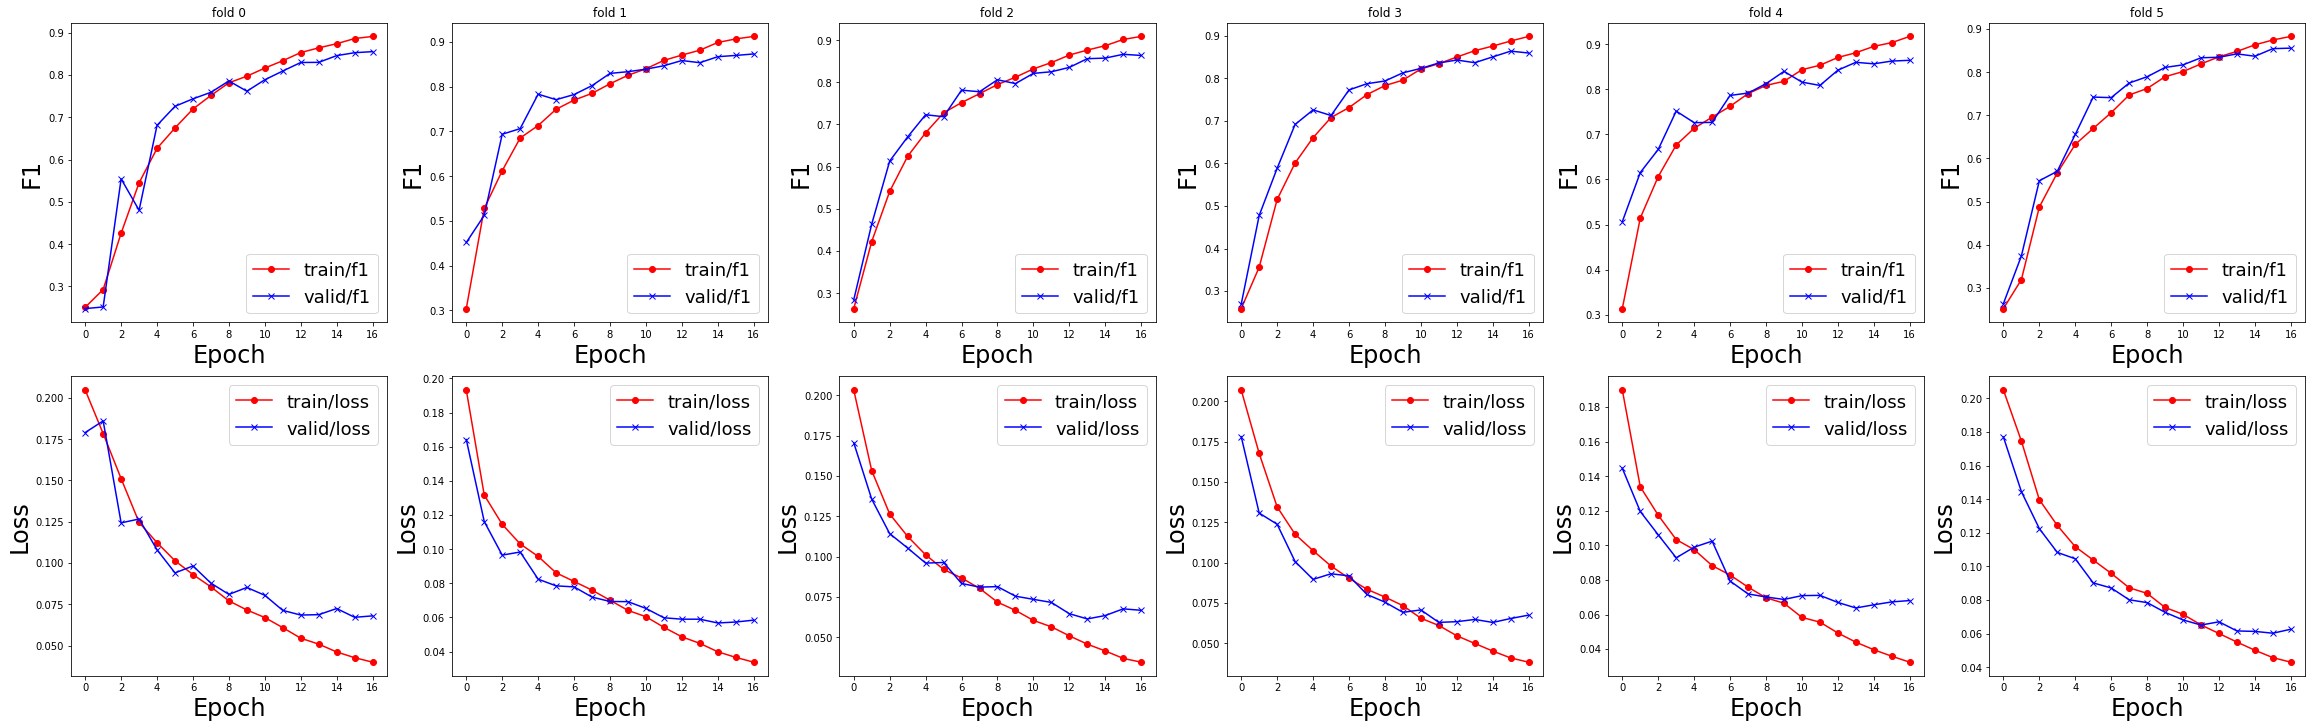

In [13]:
"""
Plot training results
"""
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(32, 10), constrained_layout=True)
gs = gridspec.GridSpec(2, CFG.n_fold, figure=fig)


for fold_idx in range(CFG.n_fold):
    tmp_log_dir = f"fold{fold_idx}_logs/{CFG.model_name}/version_0"
    metrics = pd.read_csv(os.path.join(tmp_log_dir, 'metrics.csv'))

    train_acc = metrics['train_f1'].dropna().reset_index(drop=True)
    valid_acc = metrics['valid_f1'].dropna().reset_index(drop=True)
    
    ax = fig.add_subplot(gs[0, fold_idx])
    ax.plot(train_acc, color="r", marker="o", label='train/f1')
    ax.plot(valid_acc, color="b", marker="x", label='valid/f1')
    ax.set_xlabel('Epoch', fontsize=24)
    ax.set_ylabel('F1', fontsize=24)
    ax.set_title(f'fold {fold_idx}')
    ax.legend(loc='lower right', fontsize=18)


    train_loss = metrics['train_loss'].dropna().reset_index(drop=True)
    valid_loss = metrics['valid_loss'].dropna().reset_index(drop=True)

    ax = fig.add_subplot(gs[1, fold_idx])
    ax.plot(train_loss, color="r", marker="o", label='train/loss')
    ax.plot(valid_loss, color="b", marker="x", label='valid/loss')
    ax.set_ylabel('Loss', fontsize=24)
    ax.set_xlabel('Epoch', fontsize=24)
    ax.legend(loc='upper right', fontsize=18)